In [1]:
import stella 
import matplotlib.pyplot as plt 
from glob import glob
import matplotlib.pyplot as plt

import lightkurve as lk

/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(
/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/benpope/.lightkurve/cache. Please move all the files in the legacy directory /Users/benpope/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


# Keras (JAX) model smoke test
Use a converted `.keras` model to run a quick Stella inference.

In [2]:
# Configure Keras to use the JAX backend and import libs
import os
os.environ.setdefault("KERAS_BACKEND", "jax")
import keras
import numpy as np

from stella.neural_network import ConvNN
print("Keras version:", keras.__version__)
print("Backend:", os.environ.get("KERAS_BACKEND"))

Keras version: 3.12.0
Backend: jax


In [3]:
MODELS = stella.models.models
print(MODELS)

['/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/stella/data/ensemble_s0004_i0350_b0.73_savedmodel.keras', '/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/stella/data/ensemble_s0005_i0350_b0.73_savedmodel.keras', '/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/stella/data/ensemble_s0018_i0350_b0.73_savedmodel.keras', '/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/stella/data/ensemble_s0028_i0350_b0.73_savedmodel.keras', '/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/stella/data/ensemble_s0029_i0350_b0.73_savedmodel.keras', '/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/stella/data/ensemble_s0038_i0350_b0.73_savedmodel.keras', '/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/stella/data/ensemble_s0050_i0350_b0.73_savedmodel.keras', '/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/stella/data/ensemble_s007

In [4]:
# Load the model to confirm it is readable under JAX
m = keras.models.load_model(MODELS[0], compile=False)
print("Input shape:", m.input_shape)
m.summary()

Input shape: (None, 200, 1)


Model: "stella_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 200, 16)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 64)        │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       102,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,729 (413.00 KB)

 Trainable params: 105,729 (413.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Create a minimal synthetic light curve and run ConvNN.predict
cadences = int(m.input_shape[1])
n_points = cadences * 10
t = np.arange(n_points) * 0.002  # uniform cadence
f = np.ones(n_points)            # flat flux
e = np.full(n_points, 0.001)     # small constant error
cnn = ConvNN(output_dir=".")
cnn.predict(modelname=MODELS[0], times=t, fluxes=f, errs=e)
print("Predictions shape:", cnn.predictions.shape)
print("Predictions for first series:", cnn.predictions[0][:10])

Can only use stella.ConvNN.predict().


Predictions shape: (1, 2000)
Predictions for first series: [0.06601513922214508 0.06601513922214508 0.06601513922214508
 0.06601513922214508 0.06601513922214508 0.06601513922214508
 0.06601513922214508 0.06601513922214508 0.06601513922214508
 0.06601513922214508]


/var/folders/vx/lm_q_1ld7c13_fbqfscs9n4w0000gq/T/ipykernel_27761/1945387829.py:4: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lc = search_lightcurvefile(target='tic62124646', mission='TESS', sector=13)
/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 5 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 5 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


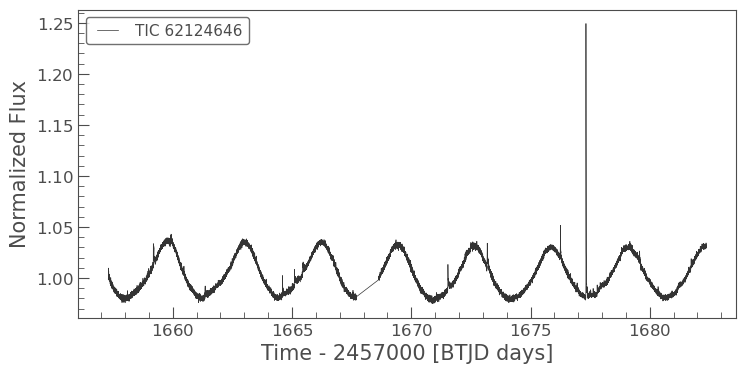

In [6]:
#### create a lightkurve for a two minute target here for the example
from lightkurve.search import search_lightcurvefile

lc = search_lightcurvefile(target='tic62124646', mission='TESS', sector=13)
lc = lc.download().normalize().remove_nans()
lc = lc[lc.quality==0]
lc.plot();


In [7]:
cnn.predict(modelname=MODELS[0],
            times=lc.time.value,
            fluxes=lc.flux.value,
            errs=lc.flux_err.value,verbose=False)
single_pred = cnn.predictions[0]


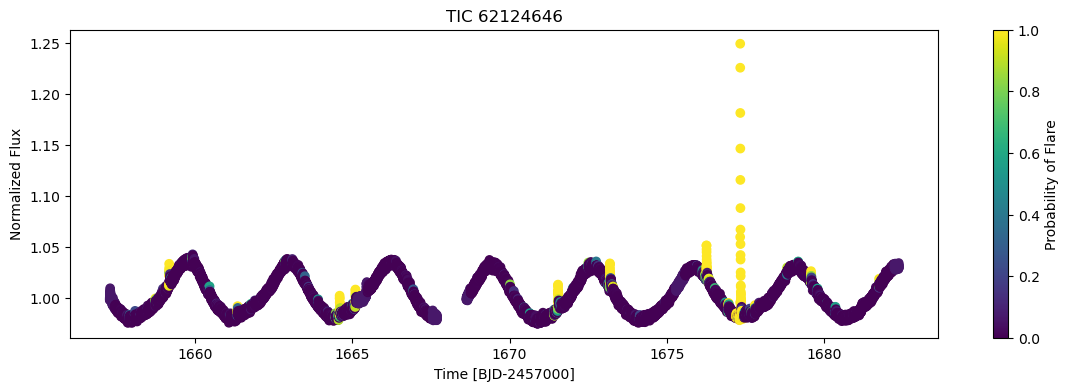

In [8]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lc.targetid));
plt.show()

In [11]:
starname = "CR Dra"

from stella.pipeline import (
    predict, predict_ensemble, predict_and_mark,
    mark_flares_from_preds, remove_false_positives,
)
from lightkurve.search import search_lightcurve
import numpy as np
import os

# 1) Download & clean the light curve
lc = search_lightcurve(target=starname, mission='TESS', exptime=120)[0].download().PDCSAP_FLUX
lc = lc.remove_nans().normalize()
lc = lc[lc.quality == 0]

# 2) Predict with a single model (the pipeline also cleans LightCurve inputs internally)
t, f, e, preds = predict(MODELS[0], lc)

# 3) Turn predictions into flare candidates
from stella.mark_flares import FitFlares
fit = FitFlares(id=np.array([lc.targetid]), time=np.array([t]), flux=np.array([f]),
                flux_err=np.array([e]), predictions=np.array([preds]))
fit.identify_flare_peaks(threshold=0.5)

# 4) Filter out obvious false positives (e.g., ultra-short fits)
filtered = remove_false_positives(fit.flare_table, min_duration_min=4.0)
print(filtered[:5])


/var/folders/vx/lm_q_1ld7c13_fbqfscs9n4w0000gq/T/ipykernel_27761/1303866805.py:12: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search_lightcurve(target=starname, mission='TESS', exptime=120)[0].download().PDCSAP_FLUX


Can only use stella.ConvNN.predict().


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]


ValueError: dtype=object is not supported by medfilt

In [10]:
t, f, e, agg, per_model = predict_ensemble(MODELS, lc, aggregate='mean')
_, flare_tab = mark_flares_from_preds(lc.targetid, t, f, e, agg, threshold=0.5)
flare_tab = remove_false_positives(flare_tab, min_duration_min=4.0)
print(flare_tab[:5])


Can only use stella.ConvNN.predict().


Can only use stella.ConvNN.predict().


Can only use stella.ConvNN.predict().


Can only use stella.ConvNN.predict().


Can only use stella.ConvNN.predict().


Can only use stella.ConvNN.predict().


Can only use stella.ConvNN.predict().


Can only use stella.ConvNN.predict().


Can only use stella.ConvNN.predict().


Can only use stella.ConvNN.predict().


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]  


ValueError: dtype=object is not supported by medfilt

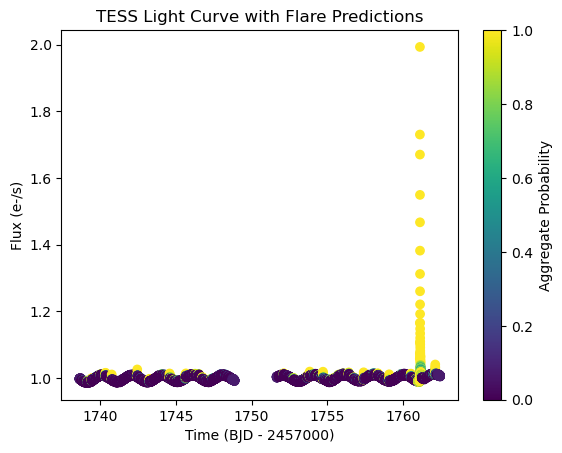

In [ ]:
plt.clf()
plt.scatter(t,f,c=agg,vmin=0,vmax=1)
plt.colorbar(label='Aggregate Probability')
plt.xlabel('Time (BJD - 2457000)')
plt.ylabel('Flux (e-/s)')
plt.title('TESS Light Curve with Flare Predictions')
plt.show()